# Use a Rugby video analysis statistic file in xml to study a match

# Basic libraries

In [23]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
plt.style.context('tableau-colorblind10')

Our file: this is a Superscout XML from Opta, a power tool that take all live actions from a live streamed match into a detailed xml collections of events, actions, that succeded during the game and tracks their actors (players), positions on the rugby pitch and get some other metrics.

In [24]:
file = '2961_RSAFvNEWZ_advanced_superscout.xml'

Using BeatifulSoap we can have a quick glance into our xml

In [25]:
from bs4 import BeautifulSoup
xml_parser = BeautifulSoup(open(file), 'xml')
print(xml_parser.prettify())

<?xml version="1.0" encoding="utf-8"?>
<OPTAFEED>
 <FXID>
  2961
  <MatchData>
   <ActionRow ActionType="407" Actionresult="0" FXID="2961" ID="0" MatchTime="1" Metres="0" PLID="900" PlayNum="0" SetNum="0" action="17" advantage="0" assoc_player="0" flag="False" period="1" player_advantage="0" psID="0" ps_endstamp="0" ps_timestamp="0" qualifier3="0" qualifier4="0" qualifier5="0" score_advantage="0" sequence_id="0" team_id="900" x_coord="50" x_coord_end="0" y_coord="34" y_coord_end="0"/>
   <ActionRow ActionType="281" Actionresult="286" FXID="2961" ID="1" MatchTime="1" Metres="0" PLID="19888" PlayNum="1" SetNum="0" action="14" advantage="0" assoc_player="0" flag="False" period="1" player_advantage="0" psID="0" ps_endstamp="0" ps_timestamp="0" qualifier3="288" qualifier4="0" qualifier5="0" score_advantage="0" sequence_id="1" team_id="900" x_coord="50" x_coord_end="84" y_coord="34" y_coord_end="60"/>
   <ActionRow ActionType="275" Actionresult="277" FXID="2961" ID="2" MatchTime="5" Metres="

We could use several strategies in order to get this xml data into a dataframe.

Per example, convert into a json and finally to a pandas dataframe to start analysis.

In [26]:
import json
# pip install xmltodict
import xmltodict

# get the xml
with open(file) as xml_file:
     
    data_dict = xmltodict.parse(xml_file.read())
    # xml_file.close()
     
    # generate the object using json.dumps()
    # corresponding to json data
     
    json_data = json.dumps(data_dict)
     
    # Write the json data to output
    # json file
    with open("data.json", "w") as json_file:
        json_file.write(json_data)
        # json_file.close()

#json_data

## Pyrugga library
Author: James Londal   https://pypi.org/project/pyrugga/


But we are going to use this dedicate library in order to deal with our match data in a easier way.

In [27]:
import pyrugga as pyr

# from xml converts to a pandas dataframe
df = pyr.Match(file)

C:\Users\Toni Andreu\AppData\Roaming\Python\Python39\site-packages\pyrugga\parse_xml.py:329: FutureWarning: Passing 'suffixes' which cause duplicate columns {'qualifier_description_x', 'qualifier_x'} in the result is deprecated and will raise a MergeError in a future version.
  actions_players = pd.merge(actions_players, descriptions, how='left', left_on = 'qualifier4', right_on = 'qualifier')
C:\Users\Toni Andreu\AppData\Roaming\Python\Python39\site-packages\pyrugga\parse_xml.py:393: FutureWarning: Passing 'suffixes' which cause duplicate columns {'qualifier_description_x', 'qualifier_x'} in the result is deprecated and will raise a MergeError in a future version.
  actions_team = pd.merge(actions_team, descriptions, how='left', left_on = 'qualifier4', right_on = 'qualifier')


IOException: 

But this library not only parses an xml file,  more important: also split the data into 4 differents dataframes to help you to analyze a rugby match: 
* 1- summary -- Summary of the match 
* 2- events -- Description of each action 
* 3- timeline -- A timeline of the match with periods ending when either possession of the ball changes or there was a stopage in play 
* 4- players -- A list of players on each team with the positions they played and length of time on the pitch


Let's briefly each dataframe.
* 1- summary -- Summary of the match 

In [28]:
df.summary

,fixture_code,ref_id,ref_name,fixture_date,fx_week,awayteam,hometeam,home_score,away_score
0,2961,1000398,Matthew Carley,02/10/2021,6,New Zealand,South Africa,31,29


that gives info about: match data, ref, teams & final scores in just one row.
Let's create some variables to use later on:

In [29]:
hometeam = df.summary.hometeam[0]
awayteam = df.summary.awayteam[0]
teams = [hometeam, awayteam]
matchdate = df.summary.fixture_date[0]
ref = df.summary.ref_name[0]
homescore = df.summary.home_score[0]
awayscore = df.summary.away_score[0]

* 2- events -- Description of each action 

In [30]:
df.events.head(10)

,action_id,additional,advantage,description,event,event_type,fixture_code,home_team_advantage,match_time,metres,...,ps_endstamp,ps_timestamp,set_num,shirt_no,team_name,x_coord,x_coord_end,y_coord,y_coord_end,points
0,0,NaN,0,NaN,Period,Start Period,2961.0,0,1,0,...,0,0,0,0.0,South Africa,50,0,34,0,0
0,1,NaN,0,Restart Long,Restart,50m Restart Kick,2961.0,0,1,0,...,0,0,0,10.0,South Africa,50,84,34,60,0
71,2,NaN,0,NaN,Collection,Restart Catch,2961.0,0,5,0,...,3,3,1,11.0,New Zealand,16,0,8,0,0
1755,3,Ineffective Tackle Contact,0,NaN,Tackle,Chase Tackle,2961.0,0,6,0,...,4,4,1,14.0,South Africa,81,0,56,0,0
1716,4,NaN,0,NaN,Missed Tackle,Bumped Off,2961.0,0,6,0,...,4,4,1,14.0,South Africa,81,0,56,0,0
1619,5,NaN,0,NaN,Attacking Qualities,Defender Beaten,2961.0,0,6,0,...,5,5,1,11.0,New Zealand,20,0,12,0,0
450,6,NaN,0,NaN,Defensive Exits,Turnover,2961.0,0,6,0,...,5,5,1,0.0,New Zealand,21,0,12,0,0
451,6,NaN,0,NaN,Defensive Exits,OOA Entry 5th Entry- Def,2961.0,0,6,0,...,5,5,1,0.0,New Zealand,21,0,12,0,0
1427,7,Neutral Contact,0,Failed Gainline,Carry,Restart Return,2961.0,0,7,6,...,6,6,1,11.0,New Zealand,16,22,8,11,0
1761,8,Neutral Tackle Contact,0,NaN,Tackle,Chase Tackle,2961.0,0,7,0,...,5,5,1,1.0,South Africa,79,0,56,0,0


So a detail info about who did what, when (match time) and where (from xy point ending to another point). So we can study event, locations, players, distances & speeds!!

Let's see some details about his dataframe.

In [31]:
df.events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4351 entries, 0 to 337
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   action_id            4351 non-null   int64  
 1   additional           2128 non-null   object 
 2   advantage            4351 non-null   int64  
 3   description          553 non-null    object 
 4   event                4351 non-null   object 
 5   event_type           2606 non-null   object 
 6   fixture_code         4351 non-null   float64
 7   home_team_advantage  4351 non-null   int64  
 8   match_time           4351 non-null   int64  
 9   metres               4351 non-null   int64  
 10  outcome              1228 non-null   object 
 11  period               4351 non-null   int64  
 12  phases               4351 non-null   int64  
 13  players_name         3832 non-null   object 
 14  position             4351 non-null   float64
 15  ps_endstamp          4351 non-null   in

So 4351 rows, 25 columns. But some nulls.

In [32]:
df.events.isna().sum()

action_id                 0
additional             2223
advantage                 0
description            3798
event                     0
event_type             1745
fixture_code              0
home_team_advantage       0
match_time                0
metres                    0
outcome                3123
period                    0
phases                    0
players_name            519
position                  0
ps_endstamp               0
ps_timestamp              0
set_num                   0
shirt_no                  0
team_name                 0
x_coord                   0
x_coord_end               0
y_coord                   0
y_coord_end               0
points                    0
dtype: int64

After a deep look of our data , we'll decide later how are going to deal with that. Anyway, seems pretty consistent data.

Let's see all the rugby events categorize by OPTA from the video of the math, now presents in our df

In [33]:
df.events['event'].value_counts()

Ruck OOA                 1588
Collection               1105
Tackle                    274
Pass                      209
Ruck                      185
Carry                     174
Attacking Qualities        91
Possession                 89
Sequence                   83
Defensive Exits            80
Kick                       71
Player Enters Field        34
Players Leavign Field      34
Missed Tackle              32
Lineout Throw              31
Defensive Actions          29
Lineout Take               29
Penalty Conceded           26
Turnover                   23
Attacking 22 Entry         21
Period                     21
Ref Review                 19
Goal Kick                  18
Offensive Scrum            18
Defensive Scrum            18
Restart                    16
Maul                       10
Counter Attack              9
Scrum                       9
Try                         5
Name: event, dtype: int64

IT's a very precise description of different actions in a rugby math. Nice!

* 3- timeline -- A timeline of the match with periods ending when either possession of the ball changes or there was a stopage in play 

In [34]:
df.timeline.head(10)

,period,set_num,team_name,points,x_coord,x_coord_end,y_coord,y_coord_end,meters_gained,dist_traveled,...,fly_half_defensive,left_wing_defensive,inside_centre_defensive,outside_centre_defensive,right_wing_defensive,full_back_defensive,New Zealand,South Africa,New Zealand_points,South Africa_points
0,1,1,New Zealand,0.0,16,43,8,16,27,28.160256,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,2,South Africa,0.0,57,75,52,5,19,50.328918,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,New Zealand,0.0,25,62,63,13,37,62.201286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,South Africa,0.0,38,86,55,62,49,48.507731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,New Zealand,0.0,14,52,8,0,38,38.832976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,South Africa,0.0,48,64,68,7,16,63.063460,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,7,South Africa,0.0,64,70,68,21,6,47.381431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,8,New Zealand,0.0,30,13,47,15,-17,36.235342,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,9,South Africa,5.0,87,102,53,64,15,18.601075,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0
9,1,10,New Zealand,3.0,50,66,33,24,16,18.357560,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,3.0,0.0


In [35]:
df.timeline.info()
df.timeline.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89 entries, 0 to 88
Columns: 182 entries, period to South Africa_points
dtypes: float64(169), int64(10), object(3)
memory usage: 127.2+ KB


period                 0
set_num                0
team_name              0
points                 0
x_coord                0
                      ..
full_back_defensive    0
New Zealand            0
South Africa           0
New Zealand_points     0
South Africa_points    0
Length: 182, dtype: int64

No nulls. Here we get all info who has the ball possession, when, where, following the score as well, and informing us if they are ganning metres, so if that action in the timeline was succesfull or not!

Let's see, per example, a cut of Hometeam's ball possession:

In [36]:
df.timeline.query('team_name == "%s"' % hometeam).head(10)

,period,set_num,team_name,points,x_coord,x_coord_end,y_coord,y_coord_end,meters_gained,dist_traveled,...,fly_half_defensive,left_wing_defensive,inside_centre_defensive,outside_centre_defensive,right_wing_defensive,full_back_defensive,New Zealand,South Africa,New Zealand_points,South Africa_points
1,1,2,South Africa,0.0,57,75,52,5,19,50.328918,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,South Africa,0.0,38,86,55,62,49,48.507731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,South Africa,0.0,48,64,68,7,16,63.063460,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,7,South Africa,0.0,64,70,68,21,6,47.381431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,9,South Africa,5.0,87,102,53,64,15,18.601075,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0
11,1,12,South Africa,3.0,61,84,51,14,23,43.566042,...,0.0,1.0,1.0,2.0,0.0,0.0,3.0,8.0,0.0,3.0
14,1,15,South Africa,0.0,57,82,55,61,25,25.709920,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,0.0,0.0
17,1,18,South Africa,0.0,69,69,68,47,0,21.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,0.0,0.0
19,1,20,South Africa,0.0,35,90,13,0,54,56.515485,...,0.0,0.0,2.0,0.0,2.0,0.0,8.0,8.0,0.0,0.0
20,1,21,South Africa,0.0,90,100,5,32,10,28.792360,...,1.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,0.0,0.0


now Away team :

In [37]:
df.timeline.query('team_name == "%s"' % awayteam).head(10)

,period,set_num,team_name,points,x_coord,x_coord_end,y_coord,y_coord_end,meters_gained,dist_traveled,...,fly_half_defensive,left_wing_defensive,inside_centre_defensive,outside_centre_defensive,right_wing_defensive,full_back_defensive,New Zealand,South Africa,New Zealand_points,South Africa_points
0,1,1,New Zealand,0.0,16,43,8,16,27,28.160256,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,3,New Zealand,0.0,25,62,63,13,37,62.201286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,New Zealand,0.0,14,52,8,0,38,38.832976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,8,New Zealand,0.0,30,13,47,15,-17,36.235342,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1,10,New Zealand,3.0,50,66,33,24,16,18.357560,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,5.0,3.0,0.0
10,1,11,New Zealand,0.0,21,39,6,17,19,21.095023,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0
12,1,13,New Zealand,5.0,50,101,34,66,51,60.207973,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,8.0,5.0,0.0
13,1,14,New Zealand,0.0,9,43,8,13,34,34.365681,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,8.0,0.0,0.0
15,1,16,New Zealand,0.0,18,28,7,14,9,12.206556,...,0.0,0.0,1.0,1.0,0.0,0.0,8.0,8.0,0.0,0.0
16,1,17,New Zealand,0.0,60,63,68,28,2,40.112342,...,0.0,0.0,1.0,0.0,0.0,0.0,8.0,8.0,0.0,0.0


* 4- players -- A list of players on each team with the positions they played and length of time on the pitch

In [38]:
df.players

,fixture_code,team_id,player_id,team_name,players_name,min,shirt_no,position
0,2961,900,23371,South Africa,Ox Nche,38,1,1
1,2961,900,18901,South Africa,Bongi Mbonambi,38,2,2
2,2961,900,19115,South Africa,Trevor Nyakane,38,3,3
3,2961,900,18903,South Africa,Eben Etzebeth,74,4,4
4,2961,900,20524,South Africa,Lood de Jager,57,5,5
5,2961,900,17107,South Africa,Siya Kolisi,56,6,6
6,2961,900,20655,South Africa,Kwagga Smith,80,7,7
7,2961,900,8986,South Africa,Duane Vermeulen,80,8,8
8,2961,900,21626,South Africa,Faf de Klerk,65,9,9
9,2961,900,19888,South Africa,Handre Pollard,80,10,10


In [39]:
df.players.info()
df.players.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   fixture_code  46 non-null     int64 
 1   team_id       46 non-null     int64 
 2   player_id     46 non-null     int64 
 3   team_name     46 non-null     object
 4   players_name  46 non-null     object
 5   min           46 non-null     int64 
 6   shirt_no      46 non-null     int64 
 7   position      46 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 3.0+ KB


fixture_code    0
team_id         0
player_id       0
team_name       0
players_name    0
min             0
shirt_no        0
position        0
dtype: int64

A rugby match has 2 teams with 15 players playing with another 15, plus 8 replacements for each team. So 23 players by team. No nulls.
Full data here: Team, name, played minutes and "tactical" role or position.

# Some Questions, some analysis

We want to summarize possession: count up the minutes each team had the ball we can sum the length field in the timeline grouping by team_name

In [40]:
df.timeline.groupby('team_name').sum()['length'] 

team_name
New Zealand     821
South Africa    946
Name: length, dtype: int64

In [41]:
# into percentatges
possessionpercens= df.timeline.groupby('team_name').sum()['length'] / (df.timeline.groupby('team_name').sum()['length'].sum())
possessionpercens.round(2)

team_name
New Zealand     0.46
South Africa    0.54
Name: length, dtype: float64

you can plot the results

In [85]:
# Creating a case-specific function to avoid code repetition
def plot_hor_bar(subplot, teams, data, event, size, percen):
    fig, ax = plt.subplots(figsize=(size+10,2))
    sns.set_theme(style="darkgrid")
    plt.subplot(1,2,subplot)
    ax = sns.barplot(x=data, y=teams, ci=None,  palette=['green','black'])
    plt.title(event, fontsize=14)
    plt.xticks(fontsize=10)
    plt.ylabel(None)
    plt.yticks(fontsize=12)
    sns.despine(left=True)
    ax.grid(False)
    
    if percen == '%':
        ax.bar_label (ax.containers[0], fmt='%.2f%%',label_type = 'edge', padding= 9.0)
        plt.xlabel('Perfomance %', fontsize=10)
    else:
        ax.bar_label (ax.containers[0], label_type = 'edge', padding= 9.0)
        plt.xlabel('Perfomance', fontsize=10)
    
    ax.tick_params(bottom=True, left=False)
    return None

Possession by team

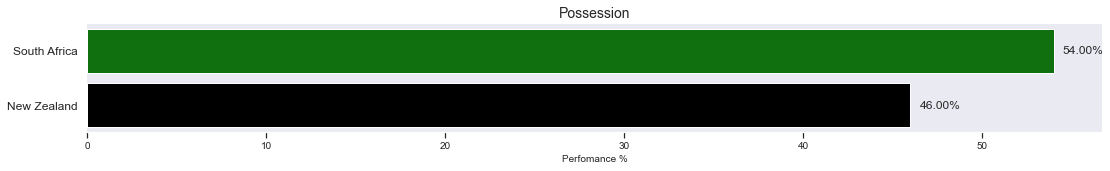

In [21]:
#y_pos = df.timeline.groupby('team_name').sum()['length']
performance = [54,46]
plot_hor_bar(1, teams, performance, 'Possession', 30, '%')
plt.show()

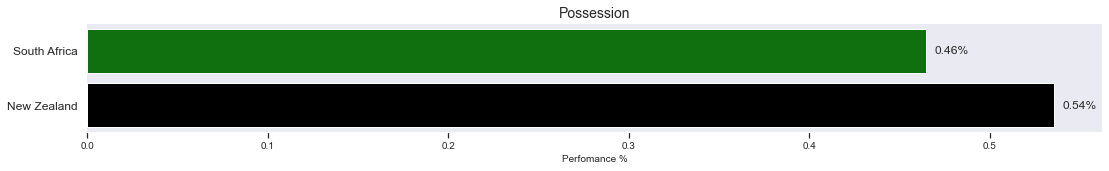

In [86]:
y_pos = df.timeline.groupby('team_name').sum()['length'] / (df.timeline.groupby('team_name').sum()['length'].sum())
performance = y_pos #[54,46]
plot_hor_bar(1, teams, performance, 'Possession', 30, '%')
plt.show()

So South Africa has more ball possession and, finally, won the match, but only by 2 points!

Let's see some other main events in play:


SCRUM

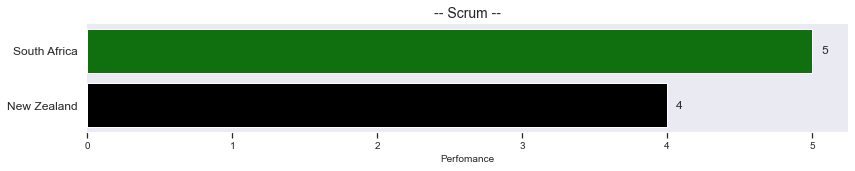

In [45]:
y_pos = df.timeline.groupby('team_name').sum()['scrum'] 
performance = y_pos #[54,46]
plot_hor_bar(1, teams, performance, '-- Scrum --', 20, '')
plt.show()

MAUL

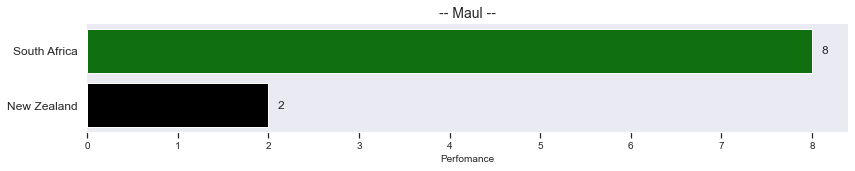

In [22]:
#y_pos = df.timeline.groupby('team_name').sum()['maul']
performance = [8,2]
plot_hor_bar(1, teams, performance, '-- Maul --', 20, '')
plt.show()

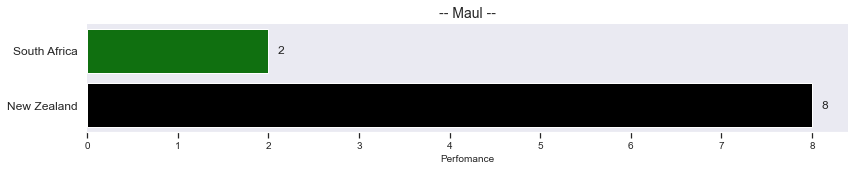

In [46]:
y_pos = df.timeline.groupby('team_name').sum()['maul']
performance = 1* y_pos #[8,2]
plot_hor_bar(1, teams, performance, '-- Maul --', 20, '')
plt.show()

LINEOUT

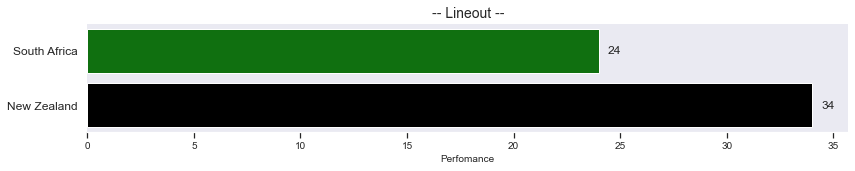

In [47]:
y_pos = df.timeline.groupby('team_name').sum()['lineout']
performance = 1* y_pos #[34,24]
plot_hor_bar(1, teams, performance, '-- Lineout --', 20, '')
plt.show()

PHASES

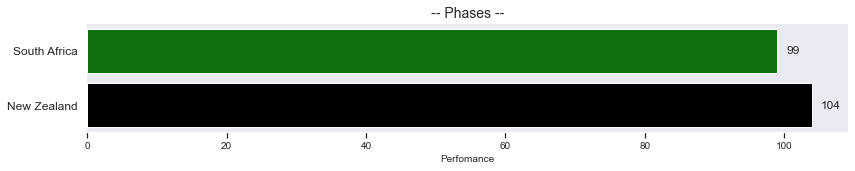

In [48]:
y_pos = df.timeline.groupby('team_name').sum()['phases']
performance = 1* y_pos #[104,99]
plot_hor_bar(1, teams, performance, '-- Phases --', 20, '')
plt.show()

This is curios: South Africa played with more continuity than NZ!

METERS GAINED

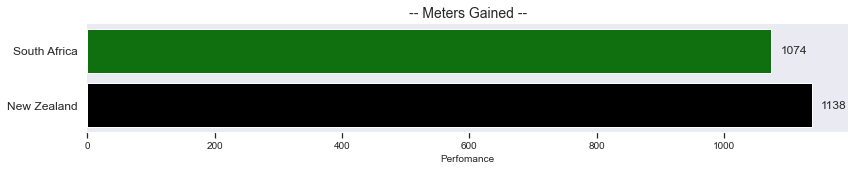

In [49]:
y_pos = df.timeline.groupby('team_name').sum()['meters_gained']
performance = 1* y_pos #[1138, 1074]
plot_hor_bar(1, teams, performance, '-- Meters Gained --', 20, '')
plt.show()

More continuity, if there is no errors, means more meters gains! So more chances to be closer to the opposite try area: so more chances to win!
Well done SA!


PASS

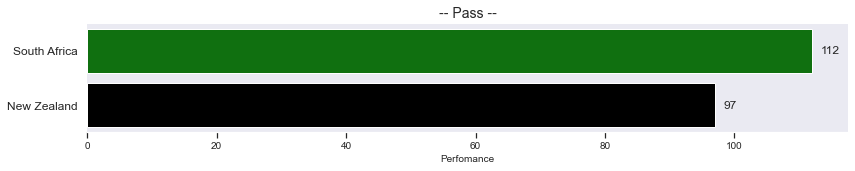

In [50]:
y_pos = df.timeline.groupby('team_name').sum()['pass']
performance = 1* y_pos #[97, 112]
plot_hor_bar(1, teams, performance, '-- Pass --', 20, '')
plt.show()

NZ keeping their play style, with less meters gain, shows more passes. Meaning more errors in pass???
Let's check it out

COMPLETE PASS = Successfull  ones!

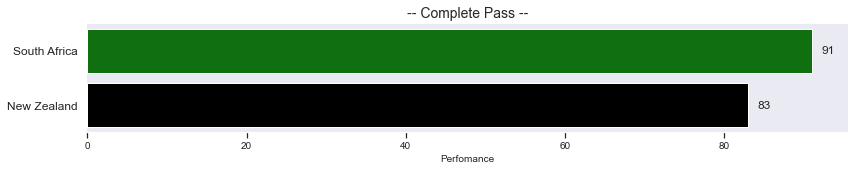

In [51]:
y_pos = df.timeline.groupby('team_name').sum()['complete_pass']
performance = 1* y_pos #[83,91]
plot_hor_bar(1, teams, performance, '-- Complete Pass --', 20, '')
plt.show()

By %

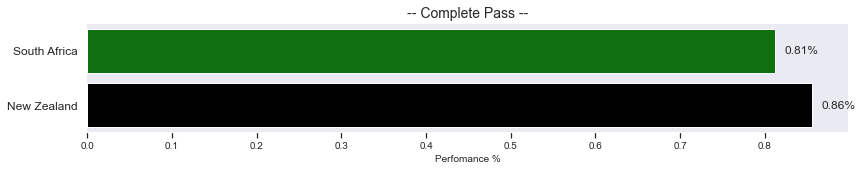

In [59]:
y_pos = df.timeline.groupby('team_name').sum()['complete_pass']/ df.timeline.groupby('team_name').sum()['pass']
performance = 1* y_pos #[83,91]
plot_hor_bar(1, teams, performance, '-- Complete Pass --', 20, '%')
plt.show()

That shows that NZ did more passes than SA, but wioth less accuracy: so more errors, less chances to win!

Let's see some aspect in the defence:
TACKLE

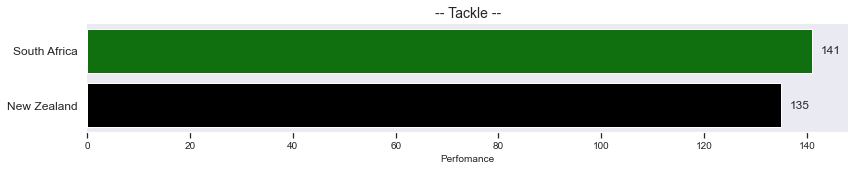

In [54]:
y_pos = df.timeline.groupby('team_name').sum()['tackle']
performance = 1* y_pos #[135,141]
plot_hor_bar(1, teams, performance, '-- Tackle --', 20, '')
plt.show()

Team with less possession, here NZ, has to deffend more, so more tackles!
Let's see their efficiency

MISSED TACKLES

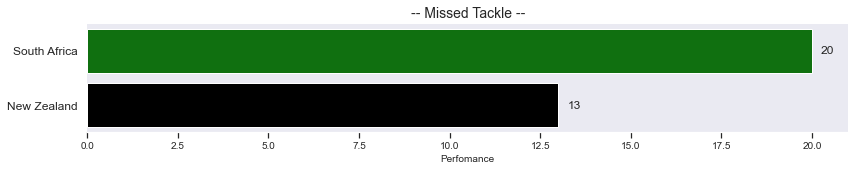

In [55]:
y_pos = df.timeline.groupby('team_name').sum()['missed_tackle']
performance = 1* y_pos #[135,141]
plot_hor_bar(1, teams, performance, '-- Missed Tackle --', 20, '')
plt.show()

in terms of success %

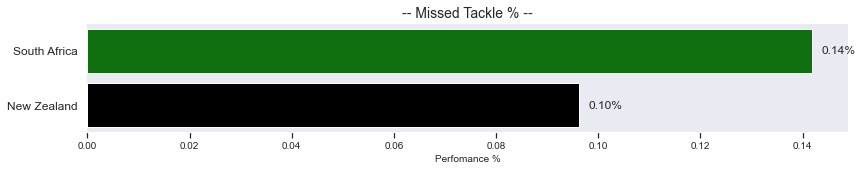

In [56]:
y_pos = df.timeline.groupby('team_name').sum()['missed_tackle'] / df.timeline.groupby('team_name').sum()['tackle']
performance = 1* y_pos #[135,141]
plot_hor_bar(1, teams, performance, '-- Missed Tackle % --', 20, '%')
plt.show()

More tackles by NZ, but less efficency than SA. Important in order to win!

JACKALS

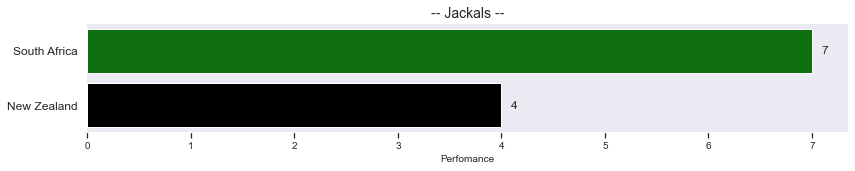

In [57]:
y_pos = df.timeline.groupby('team_name').sum()['jackal']
performance = 1* y_pos #[135,141]
plot_hor_bar(1, teams, performance, '-- Jackals --', 20, '')
plt.show()

NZ, defending more has more jackals. That's normal!

Let's some other aspects affecting ATTACK & RESULTS

PENALTYS

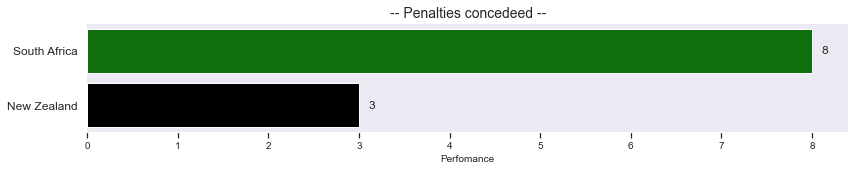

In [58]:
y_pos = df.timeline.groupby('team_name').sum()['pen_conceded']
performance = 1* y_pos #[3,8]
plot_hor_bar(1, teams, performance, '-- Penalties concedeed --', 20, '')
plt.show()

Too many for NZ, poor deffence, poor discipline!! Important factor in order to win.

PENALTIES WON

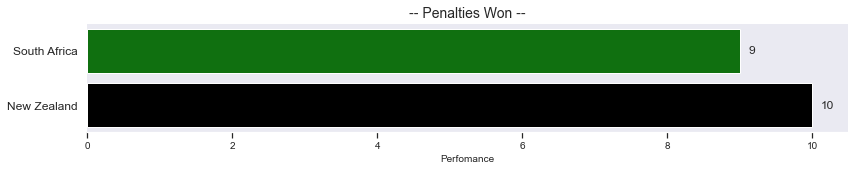

In [61]:
y_pos = df.timeline.groupby('team_name').sum()['penalty_won']
performance = 1* y_pos #[3,8]
plot_hor_bar(1, teams, performance, '-- Penalties Won --', 20, '')
plt.show()

The result, no surprise!, is best for SA.

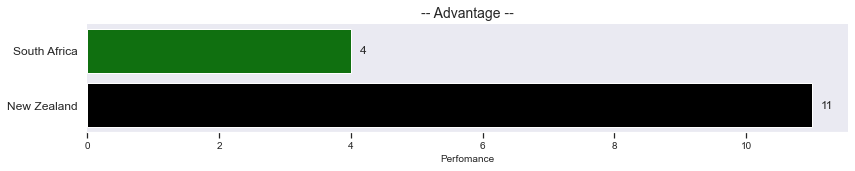

In [62]:
y_pos = df.timeline.groupby('team_name').sum()['advantage']
performance = 1* y_pos #[3,8]
plot_hor_bar(1, teams, performance, '-- Advantage --', 20, '')
plt.show()

With more possession and less hand errors, and most importnat less discipline & more faults for NZ, advantatges should be for the attacking team.

South Africa won based in these importants aspects that affect to the game:
##### 1- More possession
##### 2- wons in Scrum  & lineout & maul
##### 3- Less errors, more gain meters, more % complete passes, meaning more advantage play!
##### 4- lees tackle errors
##### 5- More penalties conceded & won

#### That's why the WON the match based in the anañysis of their match data!